<p><center><font size ="6.5", face ="Times New Roman">NetFlix Market Cap Time Series Analysis</font></center></p>

<center><font size ="5", face ="Times New Roman">Instructor: Arthur Small</font></center>

<center><font size ="5", face ="Times New Roman">Author: Qimin Luo</font></center>

In [18]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

In [19]:
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
CSS = """#notebook div.output_subarea {max-width:100%;}""" #changes output_subarea width to 100% (from 100% - 14ex)
HTML('<style>{}</style>'.format(CSS))

#  *Abstract*

<p><font size ="4", face ="Times New Roman">Netflix is one of the most successful video websites in the United States. Futher, it is also the most profitable video website in the world. It is interesting to explore its future development. In this experiment, we apply Prophet procedure to build a time series model and make preditions about its future market cap. Additionally, we also use GARCH model to fit data which is popular in the finance field. Further, we make preditions based on the best model.</font></p>

# Introduction

## Motivations

<p><font size ="4", face ="Times New Roman">Netflix is already one of the biggest media companyies in the world. Depsite this, there are some fast-growing media companies like Hulu, Youtube is running after it. We are interested to explore its future development. We plan to apply Prophet procedure to build a time series model to predict its future market cap. Its future development is impossible to be determined only by market cap. However, it is expected to find out some clues about future car development trend.</font></p>

## Literature Review

<p><font size ="4", face ="Times New Roman">The autoregressive conditional heteroscedasticity (ARCH) model is created by Robert F. Engle. In financial markets, analysts observe something called volatility clustering in which periods of low volatility are followed by periods of high volatility and vice versa. ARCH models are able to correct for the statistical problems that arise from this type of pattern in the data. As a result, they have become mainstays in modeling financial markets that exhibit volatility. [1]</font></p>

<p><font size ="4", face ="Times New Roman">To better fit seasonal data, prophet procedure is explored by Facebook. Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. [2] </font></p>

# Data and Data Generating Process

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import quandl as ql
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import fbprophet as fb

In [22]:
ql.ApiConfig.api_key = 'L1SeDskg7iEAdJ62rRTv'

<p><font size ="4", face ="Times New Roman">It is a pretty complicated and time-consuming process to retrive and well-structured data from Internet manully. In this
case, I use a convenient python financial data package -- Quandl. It contains almost unlimited financial data.
Further, it can provide us with well-formated data.</font></p>


In [23]:
data = ql.get('WIKI/NFLX')

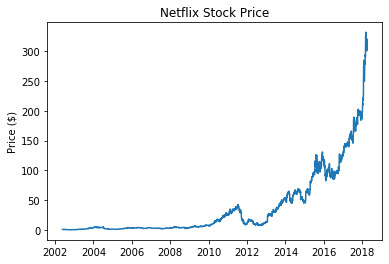

In [24]:
plt.plot(data.index, data['Adj. Close'])
plt.title('Netflix Stock Price')
plt.ylabel('Price ($)');
plt.show()

<p><font size ="4", face ="Times New Roman">The market cap of a company can be affected by lots of variables. It is reason take variables like daily stock
prices and stock vlomue into account. However, some social and political event can also have crucial effecs on
market cap. We are not able to add these things into model so we have to skip these unpredictable factors. </font></p>

<p><font size ="4", face ="Times New Roman">In this case, it is clear that variables like open price, daily highest price, daily lowest price and close price have
directive influence on its market cap. Further, stock volume is also important because it is not fair to determine
market cap by its stock price. For example, some companies have very high stock prices but its stock volume is
small. In this case, its market cap is limited by volume. Addtionally, we conisder some adjusted factors like Adj.
High since adjusted variables sometimes can demonstrate information clearly. </font></p>

$Cap\ value\ =\ Adj.Close\ Price\ *\ Stock\ volume $

In [25]:
nflx_shares = {2005: 459e6, 2006:484e6, 2007:482e6, 2008:440e6, 2009:409e6, 2010:380e6, 2011:381e6, 2012:412e6, 2013:425e6, 2014:432e6, 2015:436e6, 2016: 439e6, 2017:447e6, 2018:451e6}

In [26]:
data['Year'] = data.index.year

In [27]:
data = data[data['Year'] >= 2005]

In [28]:
data.reset_index(level=0, inplace = True)
data['cap'] = 0

In [29]:
data.head(5)

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Year,cap
0,2005-01-03,12.48,12.60,11.52,11.92,1619200.0,0.0,1.0,1.782857,1.800000,1.645714,1.702857,11334400.0,2005,0
1,2005-01-04,11.92,11.95,11.25,11.66,2478900.0,0.0,1.0,1.702857,1.707143,1.607143,1.665714,17352300.0,2005,0
2,2005-01-05,11.74,11.74,11.09,11.20,1818900.0,0.0,1.0,1.677143,1.677143,1.584286,1.600000,12732300.0,2005,0
3,2005-01-06,11.20,11.37,11.01,11.05,1181900.0,0.0,1.0,1.600000,1.624286,1.572857,1.578571,8273300.0,2005,0
4,2005-01-07,11.11,11.55,11.00,11.12,1070100.0,0.0,1.0,1.587143,1.650000,1.571429,1.588571,7490700.0,2005,0


In [30]:
for i, year in enumerate(data['Year']):
    
    shares = nflx_shares.get(year)
    data['cap'][i] = shares * data['Adj. Close'][i]

# Exploratory Data Analysis

## Data Format

<p><font size ="4", face ="Times New Roman">After the calculations and data cleaning, the data format is shown below. It is a time series data framework. There are only two attributes: 'Date' and 'Cap'. The 'Cap' indicates the Netflix market cap which we are interested in. </font></p>

In [31]:
nflx = data[['Date', 'cap']].copy()

nflx['cap'] = nflx['cap'] / 1e9

nflx.head()


,Date,cap
0,2005-01-03,0.781611
1,2005-01-04,0.764563
2,2005-01-05,0.734400
3,2005-01-06,0.724564
4,2005-01-07,0.729154


## Visualization of Cap Value

<p><font size ="4", face ="Times New Roman">We plot the data below. The blue curve notes the trend of Netflix market cap with time. The market cap grows slow before 2016 but it increases rapidly later. And its trend seems not linear and it might need log transformation to make it stationary. </font></p>

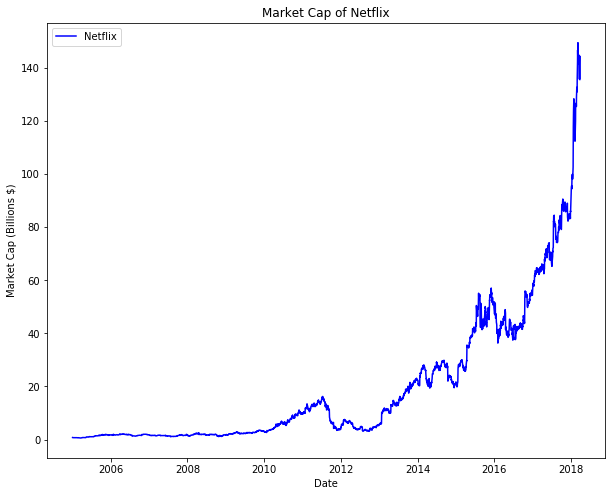

In [32]:
plt.figure(figsize=(10, 8))
plt.plot(nflx['Date'], nflx['cap'], 'b-', label = 'Netflix')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Market Cap of Netflix')
plt.legend();

In [33]:
nflx = nflx.rename(columns={'Date': 'ds', 'cap': 'y'})

# Statistical Model

## FB Prophet

### Data Generating Process

<p><font size ="4", face ="Times New Roman">Prophet Model can be roughly represented by these formulas below.</font></p>


$ y(t) = g(t) + h(t) + s(t) + \epsilon{(t)} $

$ g(t) = (k + \alpha (t)\delta)\cdot t+(m+\alpha(t)^{T}\gamma)$ （1）

$ s(t) = \sum_{n=1}^{N}(a_{n}cos(\frac{2\pi nt}{p}) + b_{n}sin(\frac{2\pi nt}{p})) $ （2）

$ h(t) = Z(t) \textbf{k} $ （3）

$ Z(t) = [1(t\in D_{1}),...,1(t\in D_{L})], \textbf{k} = (k_{1},...,k_{L})^{T}$

### Model Discussion

<p><font size ="4", face ="Times New Roman">I decide to apply Prophet Model which is explored by Facebook. Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. The financial data usually have seasonal variations and it also related with holidays. Therefore, I think this model might fit the data well.</font></p>

### Model Fitting Process

In [38]:

nf_forecast = nf_prophet.make_future_dataframe(periods=365 * 2, freq='D')


nf_forecast = nf_prophet.predict(nf_forecast)


<p><font size ="4", face ="Times New Roman">The fitting result is shown in the figure below. The black points indicate the actual data point and the blue line represents the model we fit and our predictions. Additionallly, the light blue region area states the upper bound and the lower bound of our model. However, the model didn't fit the data well based on the plot. The blue line is not close to our data and the variation area seems wide. In this case, we decided to use log transformation on the data.</font></p>

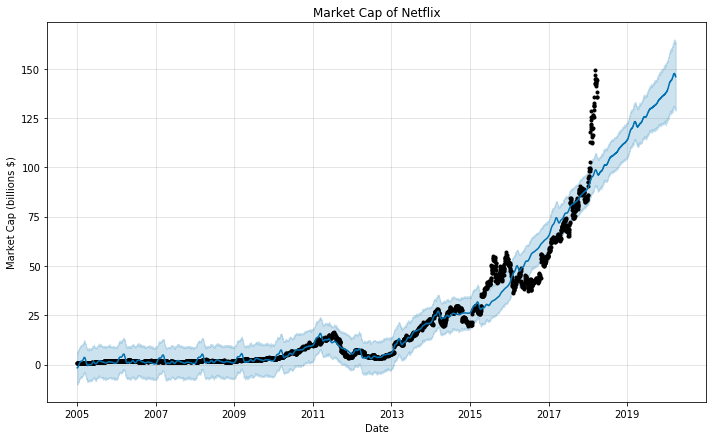

In [39]:
nf_prophet.plot(nf_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Netflix');

### Log Transformation

In [40]:
nf_log = nflx.copy()

<p><font size ="4", face ="Times New Roman">We applied log transformation on the data and the new data is shown below. Further, we also plot the trend of the new data. Though it is still not stationary enough, the trend seems much better and more close to linear relationship.</font></p>

In [43]:
nf_log.head(5)

,ds,y
0,2005-01-03,-0.246398
1,2005-01-04,-0.268451
2,2005-01-05,-0.308701
3,2005-01-06,-0.322185
4,2005-01-07,-0.315870


In [42]:
nf_log['y'] = nf_log['y'].map(lambda x: np.log(x))

In [45]:

nf_log_forecast = nf_log_prophet.make_future_dataframe(periods=365 * 2, freq='D')


nf_log_forecast = nf_log_prophet.predict(nf_forecast)


In [36]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    
    rol_mean = timeSeries.rolling(window=size).mean()
    
    rol_weighted_mean = pd.DataFrame.ewm(timeSeries, span=size).mean()

    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput


def draw_acf_pacf(ts, lags=31):
    ##plt.figure(figsize=(12, 8))
    
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.tight_layout()
    plt.show()

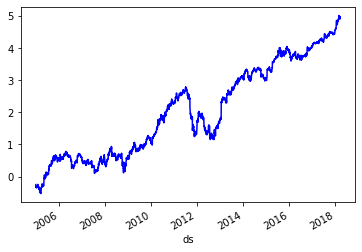

In [32]:
draw_ts(ts_log)

In [51]:
arima_data = nflx.copy()
arima_data.set_index('ds', inplace = True)

In [78]:
ts = arima_data['y'].copy()

In [79]:
ts_log = np.log(ts).copy()

## GARCH Model

In [49]:
from arch import arch_model

### Data Generating Process

<p><font size ="4", face ="Times New Roman">The autoregressive conditional heteroscedasticity (ARCH) model is a statistical model for time series data that describes the variance of the current error term or innovation as a function of the actual sizes of the previous time periods' error terms[1]; often the variance is related to the squares of the previous innovations. The ARCH model is appropriate when the error variance in a time series follows an autoregressive (AR) model; if an autoregressive moving average (ARMA) model is assumed for the error variance, the model is a generalized autoregressive conditional heteroskedasticity (GARCH) model[3].</font></p>

$r_{t} = c_{1}+\sum^{R}_{i=1}\phi_{i} r_{t-i} + \sum_{j=1}^{M}\phi_{j}\epsilon_{t-j} + \epsilon_{t}$

$\epsilon_{t} = u_{t}\sqrt{h_t}$

$h_{t} = k + \sum_{i=1}^{q}G_{i}h_{t-i} + \sum_{j=1}^{p}A_{i}\epsilon_{t-i}^2$

### Model Discussion

<p><font size ="4", face ="Times New Roman">ARCH models are commonly employed in modeling financial time series that exhibit time-varying volatility and volatility clustering, i.e. periods of swings interspersed with periods of relative calm. ARCH-type models are sometimes considered to be in the family of stochastic volatility models, although this is strictly incorrect since at time t the volatility is completely pre-determined (deterministic) given previous values[4].
In this case, the variance of stock prices is not constant so the traditional regression model is not feasible here. The variance of stock price is likely to vary with time. Therefore, GARCH model maybe be suitable in this case.</font></p>

### Model Fitting Process

In [53]:
nf_arch = arch_model(ts)

<p><font size ="4", face ="Times New Roman">Firstly, we use garch model fit the original data. Based on the result table below, R-squared is low and AIC and BIC are a bit large. Therefore, the model didn't fit the original data well. And we also made serval plots and they validated the conclusion. The PACF is fine but ACF plots demonstartes there exist high correlation between data points. What's more, the QQ plot indicates the model fitting is bad. As a result, we tried log transformation and difference transformation.</font></p>

In [55]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.464
Mean Model:             Constant Mean   Adj. R-squared:                 -0.464
Vol Model:                      GARCH   Log-Likelihood:               -8919.93
Distribution:                  Normal   AIC:                           17847.9
Method:            Maximum Likelihood   BIC:                           17872.3
                                        No. Observations:                 3330
Date:                Fri, Dec 11 2020   Df Residuals:                     3326
Time:                        14:00:09   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.7959  2.807e-02     63.985      0.000 [  1.741,  1.85

In [57]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [58]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

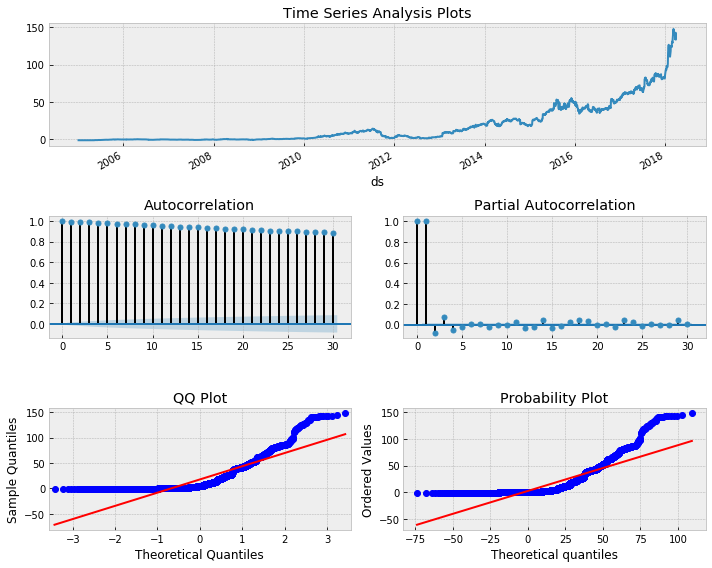

In [59]:
tsplot(res.resid, lags=30)

### Model with Log Transformation

In [62]:
nf_log_arch = arch_model(ts_log)

<p><font size ="4", face ="Times New Roman">After log transformation, the statistics is much better. In the table below, the R-squared is over 0.90 and AIC and BIC are much smalller. The trend in the plot is also more stationary and QQ plot shows the model fitting is good. However, the problem in ACF plot still exist. Correlation sometimes is not a problem for the model. We don't need to care about the correlation problem if we only want good preditions. And in this case, we want a good forcasting of Netflix market cap so the correlation problem is not crucial here. Despite this, we also tried difference transformation to fix the correlation problem.</font></p>

In [64]:
print(res_log.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.925
Mean Model:             Constant Mean   Adj. R-squared:                 -0.925
Vol Model:                      GARCH   Log-Likelihood:               -3968.96
Distribution:                  Normal   AIC:                           7945.92
Method:            Maximum Likelihood   BIC:                           7970.36
                                        No. Observations:                 3330
Date:                Fri, Dec 11 2020   Df Residuals:                     3326
Time:                        14:01:26   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.6481  6.483e-03     99.964      0.000 [  0.635,  0.66

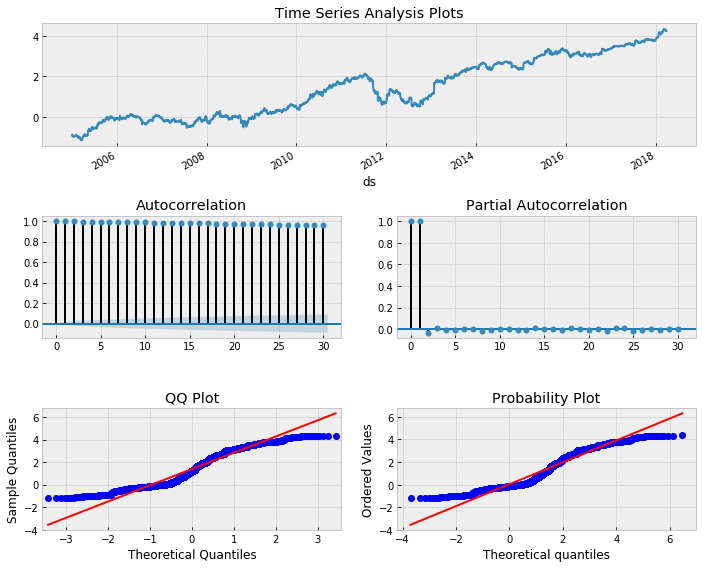

In [66]:
tsplot(res_log.resid, lags=30)

In [67]:
## diff func
def diff(y):
    base = y[0]
    tmp = y[0]
    n = len(y)
    ret = [];
    ret.append(0);
    for i in range(1, n):
        ret.append(y[i] - tmp)
        tmp = y[i]
    return base, ret

### Difference Transformation

In [68]:
base, ts_diff = diff(ts)

<p><font size ="4", face ="Times New Roman">After difference transformation, the correlation problem is fixed according to the ACF plot and PACF plot. Further, the QQ plot indicates the model fitting is good. However, the model with log transformation is closer to linear relationship compared with the model with difference transformation.</font></p>

In [70]:
nf_diff_arch = arch_model(ts_diff)

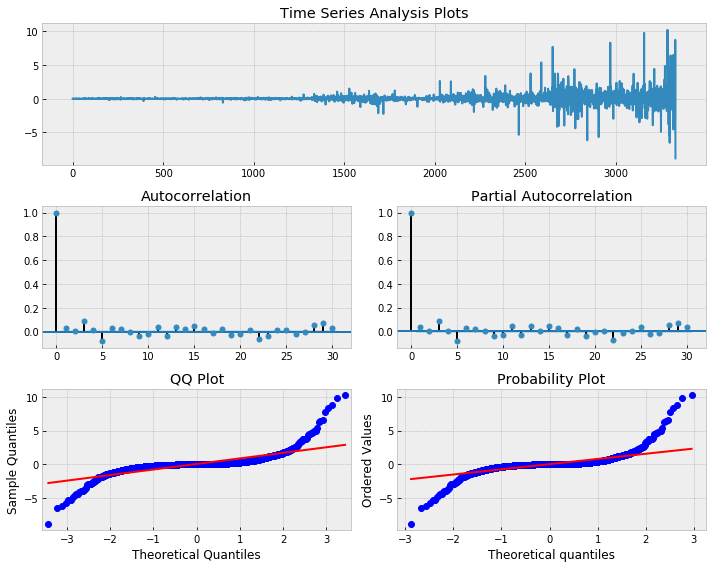

In [73]:
tsplot(res_diff.resid, lags=30)

# Results

## GARCH Simulation Forecasts

<p><font size ="4", face ="Times New Roman">Simulation-based forecasts use the model random number generator to simulate draws of the standardized residuals, $e_{t+h}$. These are used to generate a pre-specified number of paths of the variances which are then averaged to produce the forecasts. In models like GARCH which evolve in the squares of the residuals, there are few advantages to simulation-based forecasting. </font></p>

<p><font size ="4", face ="Times New Roman">Assume there are $B$ simulated paths. $A$ single simulated path is generated using</font></p>

$\sigma_{t+h,b}^2 = \omega + \alpha \epsilon_{t+h-1,b}^2 + \beta \sigma_{t+h-1,b}^2$

$\epsilon_{t+h,b} = e_{t+h,b}\sqrt{\sigma_{t+h,b}^2}$

<p><font size ="4", face ="Times New Roman">where the simulated shocks are $e_{t+1,b},e_{t+2,b},…,e_{t+h,b}$ where $b$ is included to indicate that the simulations are independent across paths. Note that the first residual, $\epsilon_{t}$, is in-sample and so is not simulated.</font></p>

<p><font size ="4", face ="Times New Roman">The final variance forecasts are then computed using the $B$ simulations</font></p>

$E_{t}[\epsilon_{t+h}^2] = \sigma_{t+h}^2 = B^{-1} \sum_{b=1}^{B} \sigma_{t+h,b}^2$

In [74]:
forecasts = res_diff.forecast(horizon=10)

## Discussion and Conclusion

<p><font size ="4", face ="Times New Roman">  We used GARCH model predict volatilities but there is a trade-off. If we are more interested in the relationship between data points, the model with difference transformation is more suitable. If we only care about the preditions, we could apply the model with log transformation though it has the correlation problem.</font></p>

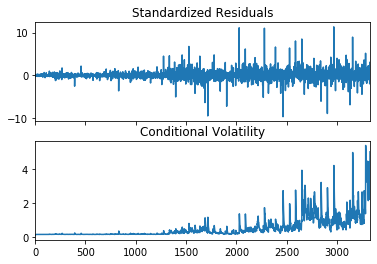

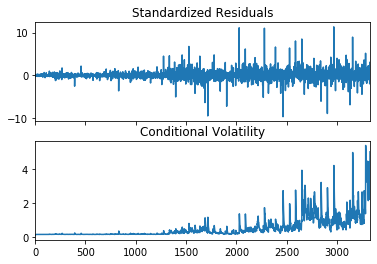

In [75]:
res_diff.plot()

In [66]:
forecasts = res_diff.forecast(horizon=10, method='simulation')

<p><font size ="4", face ="Times New Roman">The prophet also has a good performance with log transformation. We can conclude that the market cap of Netflix will keep high increasing rate based on our model and the fact actually validates that. Despite this, the model might have overfitting problem. One simple way of mitigating ovefitting is to perform extensive back-testing. In practice, it means the process needs to split the input dataset over dozens - if not hundreds - of incremental date thresholds, and re-train all the forecasting models and re-assess them each time. Backtesting requires a lot of processing power. In the future work, this method can be used to solve overfitting problem. Moreover, the Netflix had a big jump during the quarantine. It is hard to consider the unexpected events in the model and it is always a big issue in time series analysis. Prophet model partly takes these events into considerations but it is not enough. I hope there will a more advanced model can solve this problem in the future for better preditions.</font></p>

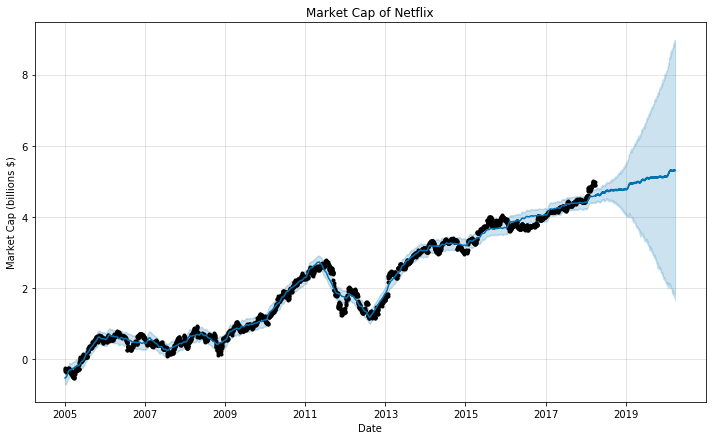

In [76]:
nf_log_prophet.plot(nf_log_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Netflix');

# Reference

[1] Engle, Robert F. (1982). "Autoregressive Conditional Heteroscedasticity with Estimates of the Variance of United Kingdom Inflation". Econometrica. 50 (4): 987–1007. doi:10.2307/1912773. JSTOR 1912773.

[2] https://facebook.github.io/prophet/
  
[3] Bollerslev, Tim (1986). "Generalized Autoregressive Conditional Heteroskedasticity". Journal of Econometrics. 31 (3): 307–327. CiteSeerX 10.1.1.468.2892. doi:10.1016/0304-4076(86)90063-1.

 
[4] Brooks, Chris (2014). Introductory Econometrics for Finance (3rd ed.). Cambridge: Cambridge University Press. p. 461. ISBN 9781107661455.
 
